In [4]:
import torch
import torch.nn
import torch.nn.functional as F
from torch.nn import Linear, Parameter
from torch.nn.init import xavier_uniform_, zeros_
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, remove_self_loops, degree, softmax

from torch_geometric.datasets import MoleculeNet
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn import metrics

from itertools import product
import io, os, json
import time

import py3Dmol
from rdkit import Chem

import pandas as pd
import numpy as np
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.templates.default = 'plotly_white'

# The Model

In [3]:
class EIN(MessagePassing):
    """
    A Edge featured attention based Graph Neural Network Layer for Graph Classification / Regression Tasks
    """
    def __init__(
        self,
        in_channels,
        out_channels,
        heads=1,
        negative_slope=0.2,
        dropout=0.0,
        edge_dim=None,
        train_eps = False,
        eps = 0.0,
        bias=True,
        share_weights=False,
        **kwargs,
    ):
        super().__init__(node_dim=0, aggr='add' , **kwargs) # defines the aggregation method: `aggr='add'`

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.share_weights = share_weights
        self.edge_dim = edge_dim
        self.initial_eps = eps

        # Linear Transformation
        self.lin_l = Linear(in_channels, heads * out_channels, bias=bias)

        if share_weights:
            self.lin_r = self.lin_l # use same matrix
        else:
            self.lin_r = Linear(in_channels, heads * out_channels, bias=bias)

        # For attention calculation
        self.att = Parameter(torch.Tensor(1, heads, out_channels))

        # For influence mechanism
        self.inf = Linear(edge_dim, out_channels)

        # Tunable parameter for adding self node features...
        if train_eps:
            self.eps = torch.nn.Parameter(torch.Tensor([eps]))
        else:
            self.register_buffer('eps', torch.Tensor([eps]))

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self._alpha = None # alpha weights

        self.reset_parameters()


    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()
        self.inf.reset_parameters()
        self.eps.data.fill_(self.initial_eps)
        xavier_uniform_(self.att)
        zeros_(self.bias)


    def forward(self, x, edge_index, edge_attr=None, return_attention_weights=None):
        ## N - no_of_nodes, NH - no_of heads,  H_in - input_channels, H_out - out_channels

        H, C = self.heads, self.out_channels

        x_l = None # for source nodes
        x_r = None # for target nodes

        x_l = self.lin_l(x).view(-1, H, C) # (N, H_in) -> (N, NH, H_Out)
        if self.share_weights:
            x_r = x_l
        else:
            x_r = self.lin_r(x).view(-1, H, C)

        assert x_l is not None
        assert x_r is not None

        # Check the edge features shape: test_case
        if edge_attr is not None:
            print(f'edge_features shape: {edge_attr.shape}')
        else:
            print('No edge features!')

        # Start propagating info...: construct message -> aggregate message -> update/obtain new representations
        out = self.propagate(edge_index, x=(x_l, x_r), edge_attr=edge_attr, size=None) # (N, H_out)
        # out += x_r.mean(dim=1) # add the self features

        alpha = self._alpha # (#edges, 1)
        assert alpha is not None, 'Alpha weights can not be None value!'

        if self.bias is not None:
            out = out + self.bias

        # Returning attention weights with computed hidden features
        if isinstance(return_attention_weights, bool):
                return out, alpha.mean(dim=1, keepdims=True)
        else:
            return out # (N, H_out)


    def message(self, x_j, x_i, index, size_i, edge_attr):
        # x_j has shape [#edges, NH, H_out]
        # x_i has shape [#edges, NH, H_out]
        # index: target node indexes, where data flows 'source_to_target': this is for computing softmax
        # size: size_i, size_j mean num_nodes in the graph

        x = x_i + x_j # adding(element-wise) source and target node features together to calculate attention
        x = F.leaky_relu(x, self.negative_slope)
        alpha = (x * self.att).sum(dim=-1) # (#edges, NH)
        alpha = softmax(alpha, index, num_nodes=size_i) # spares softmax: groups node's attention and then node-wise softmax
        self._alpha = alpha.mean(dim=1, keepdims=True) # (#edges, 1)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training) # randomly dropping attention during training
        node_out = (x_j * alpha.unsqueeze(-1)).mean(dim=1)


        if self.inf is not None and edge_attr is not None:
            if self.edge_dim != edge_attr.size(-1):
                raise ValueError("Node and edge feature dimensionalities do not "
                                "match. Consider setting the 'edge_dim' ""attribute")
            edge_attr = self.inf(self._alpha * edge_attr) # transformed edge features via influence mechanism
            return node_out + edge_attr  # (#edges, H_out)
        return node_out # (#edges, H_out)


    def update(self, aggr_out, x):
        aggr_out += (1 + self.eps) * x[1].mean(dim=1) # add the self features with a weighting factor
        return aggr_out # (N, H_out)


    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, heads={self.heads})')


# Dataset

The Blood-brain barrier penetration (BBBP) dataset comes from a recent study 52 on the modeling and prediction of the barrier permeability. A a membrane separating circulating blood and brain extracellular fluid, the blood-brain barrier blocks most drugs, hormones an neurotransmitters. Thus penetration of the barrier forms a long-standing issue in development of drugs targeting central nervous system. This dataset includes binary labels for over 2000 compounds on their permeability properties. Scaffold splitting is also recommended for this well-defined target.

In [11]:
# os.makedirs('./data/bbbp', exist_ok=True)

dataset = MoleculeNet(root='./data', name='BBBP')

print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

graph_1 = dataset[0]
print()
print(graph_1)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {graph_1.num_nodes}')
print(f'Number of edges: {graph_1.num_edges}')
print(f'Average node degree: {graph_1.num_edges / graph_1.num_nodes:.2f}')
print(f'Has isolated nodes: {graph_1.has_isolated_nodes()}')
print(f'Has self-loops: {graph_1.has_self_loops()}')
print(f'Is undirected: {graph_1.is_undirected()}')


Dataset: BBPB(2039):
Number of graphs: 2039
Number of features: 9
Number of classes: 2

Data(x=[20, 9], edge_index=[2, 40], edge_attr=[40, 3], y=[1, 1], smiles='[Cl].CC(C)NCC(O)COc1cccc2ccccc12')
Number of nodes: 20
Number of edges: 40
Average node degree: 2.00
Has isolated nodes: True
Has self-loops: False
Is undirected: True


# Visualization of the molecules

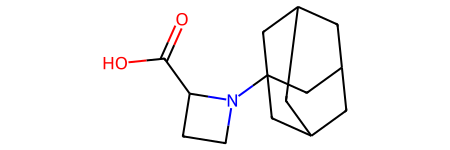

In [22]:
i = np.random.randint(len(dataset))
m = Chem.MolFromSmiles(dataset[i].smiles)
m

# Feature Engineering

In [50]:
def create_df(dataset):
    for i in range(len(dataset)):
        x_i = dataset[i].x.cpu().detach().numpy()
        x = x_i if i == 0 else np.vstack([x, dataset[i].x.cpu().detach().cpu()])

        y_i = dataset[i].y.cpu().detach().numpy()
        y = y_i if i == 0 else np.vstack([y, dataset[i].y.cpu().detach().numpy()])

    df_x = pd.DataFrame(x)
    df_y = pd.DataFrame(y)

    df_x.columns = [
    'atomic_num', 'chirality', 'degree', 'formal_charge',
    'numH', 'number_radical_e', 'hybridization',
    'is_aromatic', 'is_in_ring'
    ]

    df_y.columns = ['permeability']

    print(f'Shape of node_feature df: {df_x.shape}')
    print(f'Shape of target df: {df_y.shape}')

    return df_x, df_y

In [53]:
df_x, df_y = create_df(dataset)
df_x.head()

Shape of node_feature df: (49068, 9)
Shape of target df: (2039, 1)


atomic_num  chirality  degree  formal_charge  numH  number_radical_e  \
0          17          0       0              5     0                 1   
1           6          0       4              5     3                 0   
2           6          0       4              5     1                 0   
3           6          0       4              5     3                 0   
4           7          0       3              5     1                 0   

   hybridization  is_aromatic  is_in_ring  
0              4            0           0  
1              4            0           0  
2              4            0           0  
3              4            0           0  
4              4            0           0

In [54]:
df_y.head()

permeability
0           1.0
1           1.0
2           1.0
3           1.0
4           1.0

## Node Feature Distribution

In [52]:
for col in df_x:
    px.histogram(
        df_x, col, histnorm='percent',
        height=300, width=500, title='Distribution of ' + col
    ).show()

## Target Class Distribution

Binary labels of blood-brain barrier penetration(permeability)

In [57]:
px.histogram(
    df_y, 'permeability', histnorm='percent',
    height=300, width=500, title='Distribution of Target: Permeability'
).show()

Looks like we have class-imbalance here!, most of the labels (76%) have permeability set to true. Hence distribution is skewed one.

In [47]:
cols_to_normalize = [
    'atomic_num', 'degree',
    'formal_charge',
    'numH',
    'number_radical_e'
]

cols_to_encode = [
    'chirality',
    'hybridization'
]

METHOD = 'min-max'

